In [22]:
# Cell 1: Setup & imports
# Run once at notebook start.

import os
import sys
import json
import math
import glob
import random
import warnings
from pathlib import Path
from tqdm import tqdm

# Data & ML
import numpy as np
import pandas as pd

# NLP / Transformers
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# CV
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: transformer and torch (might download models)
import torch

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

warnings.filterwarnings('ignore')

print("Environment ready. Python version:", sys.version.split()[0])


Environment ready. Python version: 3.11.7


In [47]:
# Cell 2: Data paths & helper utilities

from pathlib import Path
import glob
import os

# IMPORTANT: Use RAW STRING (r"...") for Windows paths when using Jupyter
BASE_DIR = Path.cwd()

# Use your actual project root folder here
DATA_DIR = Path(r"C:\Data Science & Business Analysis\Project Root\Data")

RESUME_DIR = DATA_DIR / "Resume"
VIDEO_DIR = DATA_DIR / "videos"
OUTPUT_DIR = DATA_DIR / "outputs"
MODEL_DIR = DATA_DIR / "models"

# Create folders if missing
for p in [DATA_DIR, RESUME_DIR, VIDEO_DIR, OUTPUT_DIR, MODEL_DIR]:
    os.makedirs(p, exist_ok=True)

print("Expected data locations:")
print("  Resume :", RESUME_DIR)
print("  Videos :", VIDEO_DIR)
print("  Outputs:", OUTPUT_DIR)
print("  Models :", MODEL_DIR)

# Helper: safe file list
def list_files(folder, extensions=None):
    extensions = extensions or ['*']
    files = []
    for ext in extensions:
        files.extend(sorted(map(Path, glob.glob(str(folder / f"**/*.{ext}"), recursive=True))))
    return files

# Example usage
print("Found resumes:", len(list(RESUME_DIR.glob("*.pdf"))))
print("Found videos:", len(list(VIDEO_DIR.glob("*.*"))))


Expected data locations:
  Resume : C:\Data Science & Business Analysis\Project Root\Data\Resume
  Videos : C:\Data Science & Business Analysis\Project Root\Data\videos
  Outputs: C:\Data Science & Business Analysis\Project Root\Data\outputs
  Models : C:\Data Science & Business Analysis\Project Root\Data\models
Found resumes: 80
Found videos: 150


In [48]:
# Cell 3: Resume PDF text extraction (pdfminer.six recommended)
# pip install pdfminer.six if not installed

from pdfminer.high_level import extract_text

def extract_text_from_pdf(pdf_path):
    try:
        text = extract_text(str(pdf_path))
        return text
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return ""

# Example: build a DataFrame of resumes with extracted text
resume_files = list(RESUME_DIR.glob("*.pdf"))
resume_records = []
for p in resume_files:
    txt = extract_text_from_pdf(p)
    resume_records.append({"candidate_id": p.stem, "resume_path": str(p), "text_raw": txt})

resumes_df = pd.DataFrame(resume_records)
print("Resumes processed:", len(resumes_df))
resumes_df.head(1)


Resumes processed: 80


,candidate_id,resume_path,text_raw
0,1 - Ishan Subhashana,C:\Data Science & Business Analysis\Project Ro...,B.Sc. (Hons) in Artificial Intelligence & Data...


In [50]:
print(resumes_df.iloc[0]["text_raw"])


B.Sc. (Hons) in Artificial Intelligence & Data Science- University of Moratuwa 

MY PROFILE 

Motivated undergraduate in Artificial Intelligence & Data Science with a foundational understanding of Python and 
Excel. Enthusiastic about exploring data science concepts through coursework and online resources. Eager to gain 
practical exposure through internships and entry-level opportunities. 

EDUCATION 

B.Sc. (Hons) in Artificial Intelligence & Data Science- University of Moratuwa 

EXPERIENCE 

Participated in university group projects only. 

Assisted peers in preparing simple data visualizations for class presentations. 

PROJECTS 

•  Kaggle House Prices EDA 

Performed exploratory data analysis on the house price dataset. Generated simple visualizations using Python 
libraries.. 

•  Titanic Survival Prediction 

Implemented logistic regression on the Titanic dataset. Compared model accuracy with baseline predictions. 

•  Movie Ratings Analysis (Mini Project) 

Collected a small 

In [65]:
# -------- FIXED & CLEANED SECTION SEGMENTATION -------- #

import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define clean, strict section headers
HEADER_PATTERNS = {
    "experience": r"^(experience|work experience)$",
    "education": r"^(education|academic background)$",
    "skills": r"^(skills|technical skills|additional information)$",
    "projects": r"^(projects|project experience)$",
    "certifications": r"^(certifications|licenses|certification)$",
    "awards": r"^(awards|achievements)$"
}

def clean_text(text):
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'[ \t]+', ' ', text)
    return text.strip()

def identify_header(line):
    """Return section name if line is a valid header."""
    l = line.lower().strip()
    for sec, pattern in HEADER_PATTERNS.items():
        if re.match(pattern, l):
            return sec
    return None

def section_segment(text):
    lines = text.splitlines()
    sections = {k: "" for k in HEADER_PATTERNS.keys()}
    curr = None
    header_found = False  # to avoid capturing intro text
    
    for line in lines:
        ln = line.strip()

        # Skip empty lines
        if not ln:
            continue
        
        # Check if this line is a recognized header
        new_header = identify_header(ln)
        if new_header:
            curr = new_header
            header_found = True
            continue
        
        # Ignore intro lines BEFORE first real header
        if not header_found:
            continue
        
        # Collect text under the current section
        if curr:
            sections[curr] += ln + " "
    
    return sections

def preprocess_resume_row(row):
    text = clean_text(row['text_raw'])
    sections = section_segment(text)
    return sections

# Test again
example = resumes_df.iloc[0]
sections = preprocess_resume_row(example)

print("Extracted sections:")
for k, v in sections.items():
    print(f"{k} -> {v[:120]}...")



Extracted sections:
experience -> Participated in university group projects only. Assisted peers in preparing simple data visualizations for class present...
education -> B.Sc. (Hons) in Artificial Intelligence & Data Science- University of Moratuwa ...
skills -> Technical Skills: Python (beginner), Excel (basic), Jupyter Notebook (basic), Matplotlib (basic) Soft Skills:Teamwork, w...
projects -> • Kaggle House Prices EDA Performed exploratory data analysis on the house price dataset. Generated simple visualization...
certifications -> ...
awards -> ...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Subhashana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Subhashana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Subhashana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
# Cell 5: Keyword lists & resume section scoring (FIXED VERSION)

import string

# Extended DS keyword list
DS_KEYWORDS = [
    'python','r','sql','pandas','numpy','scikit-learn','tensorflow','pytorch',
    'machine learning','deep learning','nlp','computer vision','forecast','time series',
    'regression','classification','xgboost','random forest','etl','data pipeline',
    'model deployment','docker','kubernetes','aws','gcp','azure','power bi','tableau',
    'spark','hadoop','matplotlib','seaborn','keras','statistics','probability',
    'bayesian','reinforcement learning','bert','roberta','gpt','attention','nosql',
    'postgres','mysql'
]

# Section weights
SECTION_WEIGHTS = {
    "experience": 30,
    "skills": 20,
    "projects": 15,
    "education": 15,
    "certifications": 10,
    "awards": 10
}

def clean_for_keywords(text):
    """Remove bullets, punctuation, lowercase text for consistent matching."""
    if not text:
        return ""
    
    text = text.lower()
    text = text.replace("•", " ")
    text = text.replace("-", " ")
    text = text.replace("–", " ")
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)   # remove special chars
    text = re.sub(r"\s+", " ", text)
    return text

def keyword_score(text, keywords):
    text_low = clean_for_keywords(text)
    score = 0
    found = []

    for kw in keywords:
        kw_low = kw.lower()
        if kw_low in text_low:
            score += 1
            found.append(kw)
    return score, found

def score_resume_sections(sections_dict):
    section_scores = {}
    
    for sec, weight in SECTION_WEIGHTS.items():
        text = sections_dict.get(sec, "")
        cleaned = clean_for_keywords(text)
        s, found = keyword_score(cleaned, DS_KEYWORDS)

        section_scores[sec] = {
            "raw_count": s,
            "found": found,
            "weighted": weight * math.log1p(s)
        }

    return section_scores

# Test scoring again
if not resumes_df.empty:
    example = resumes_df.iloc[0]
    secs = preprocess_resume_row(example)
    sc = score_resume_sections(secs)
    print("\nFixed Resume Scoring:")
    for k, v in sc.items():
        print(f"{k}: {v}")



Fixed Resume Scoring:
experience: {'raw_count': 1, 'found': ['r'], 'weighted': 20.79441541679836}
skills: {'raw_count': 3, 'found': ['python', 'r', 'matplotlib'], 'weighted': 27.725887222397812}
projects: {'raw_count': 3, 'found': ['python', 'r', 'regression'], 'weighted': 20.79441541679836}
education: {'raw_count': 1, 'found': ['r'], 'weighted': 10.39720770839918}
certifications: {'raw_count': 0, 'found': [], 'weighted': 0.0}
awards: {'raw_count': 0, 'found': [], 'weighted': 0.0}


In [27]:
pip install transformers sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [29]:
# Cell 6: Contextual embeddings (Sentence-BERT) for semantic similarity
# pip install sentence-transformers

from sentence_transformers import SentenceTransformer

# Use a reasonably small SBERT model for speed (change if you prefer larger)
MODEL_NAME = "all-MiniLM-L6-v2"  # good tradeoff: small + decent quality

print("Loading sentence-transformers model:", MODEL_NAME)
sbert = SentenceTransformer(MODEL_NAME)

def get_text_embedding(text):
    if not text or text.strip()=="":
        return np.zeros(sbert.get_sentence_embedding_dimension())
    emb = sbert.encode(text, show_progress_bar=False)
    return emb

# Example: compute ideal candidate vector (you can tune this by composing a "job profile")
ideal_profile_text = """
Experienced data scientist with strong Python skills, SQL knowledge, expertise in machine learning,
model deployment, data pipelines, and visualization (Power BI/Tableau). Demonstrated project leadership.
"""
ideal_vec = get_text_embedding(ideal_profile_text)
print("Ideal embedding dim:", ideal_vec.shape)

# Compute semantic score: cosine similarity of candidate resume full text to ideal vector
if not resumes_df.empty:
    txt = resumes_df.iloc[0]['text_raw']
    emb = get_text_embedding(txt)
    sim = cosine_similarity([emb], [ideal_vec])[0][0]
    print("Semantic similarity sample:", sim)


Loading sentence-transformers model: all-MiniLM-L6-v2
Ideal embedding dim: (384,)
Semantic similarity sample: 0.54821813


In [67]:
# Cell 7: Final resume score (0-60)

ALPHA = 0.15  # weight for semantic similarity contribution (tunable)
MAX_RESUME_POINTS = 60

def compute_resume_score(sections_text_map, ideal_emb, alpha=ALPHA):
    section_scores = score_resume_sections(sections_text_map)
    # sum of weighted values (we used weighted = weight * log1p(count))
    raw_sum = sum([v['weighted'] for v in section_scores.values()])
    # normalize raw_sum to 0-1 by a soft heuristic or max observed value
    # For prototype, set a normalization constant (tune later)
    norm = raw_sum / (sum(SECTION_WEIGHTS.values()) * 2.0)  # heuristic denominator
    norm = min(1.0, norm)
    # semantic similarity
    full_text = " ".join(sections_text_map.values())
    emb = get_text_embedding(full_text) if full_text.strip() else np.zeros_like(ideal_emb)
    sem_sim = float(cosine_similarity([emb], [ideal_emb])[0][0])
    # final 0-60
    resume_points = norm * (MAX_RESUME_POINTS * (1 - alpha)) + (sem_sim * MAX_RESUME_POINTS * alpha)
    return {
        "section_scores": section_scores,
        "norm": norm,
        "semantic_similarity": sem_sim,
        "resume_points": resume_points
    }

# example for first resume
if not resumes_df.empty:
    secs = preprocess_resume_row(resumes_df.iloc[0])
    r = compute_resume_score(secs, ideal_vec)
    print("Resume points sample:", r['resume_points'])
else:
    print("Add resumes in data/resumes/ to test scoring.")


Resume points sample: 25.18361711877141


In [68]:
# --- Cell 8: Apply Scoring to All Resumes and Rank ---

def process_and_score_resume(row, ideal_emb, alpha=ALPHA):
    """
    Applies the full pipeline (cleaning, segmentation, scoring) to a single resume row.
    """
    # Step 1: Clean and segment the text (from Cell 4)
    sections_text_map = preprocess_resume_row(row)

    # Step 2: Compute the final composite score (from Cell 7)
    results = compute_resume_score(sections_text_map, ideal_emb, alpha)

    # Step 3: Extract relevant metrics
    final_score = results['resume_points']
    semantic_similarity = results['semantic_similarity']
    norm_keyword_score = results['norm']
    
    # Store section-wise keyword counts for detailed inspection (e.g., 'experience_count')
    section_counts = {
        f"{k}_count": v['raw_count'] 
        for k, v in results['section_scores'].items()
    }
    
    # Combine all results into a single dictionary
    return {
        "score_total": final_score,
        "score_semantic": semantic_similarity,
        "score_keyword_norm": norm_keyword_score,
        **section_counts
    }

# --- Apply the function to the entire DataFrame ---

if not resumes_df.empty:
    # We use apply() with axis=1 to process row-by-row
    scoring_results = resumes_df.apply(
        lambda row: process_and_score_resume(row, ideal_vec, ALPHA), 
        axis=1, 
        result_type='expand' # Expands the returned dictionary into new columns
    )

    # Merge the new scoring columns back into the main DataFrame
    resumes_df = pd.concat([resumes_df, scoring_results], axis=1)

    # --- Ranking and Display ---
    
    # Sort the DataFrame by the total score in descending order
    resumes_ranked_df = resumes_df.sort_values(by='score_total', ascending=False)

    print(f"--- Top {min(10, len(resumes_ranked_df))} Ranked Resumes ---")
    
    # Display key columns: ID, Final Score, Semantic Score, and Normalized Keyword Score
    display_cols = ['candidate_id', 'score_total', 'score_semantic', 'score_keyword_norm']
    
    # Add the top 3 keyword counts for quick review
    top_counts = sorted([col for col in resumes_ranked_df.columns if '_count' in col], 
                        key=lambda x: resumes_ranked_df[x].sum(), reverse=True)[:3]
    
    print(resumes_ranked_df[display_cols + top_counts].head(10).to_markdown(index=False))
else:
    print("DataFrame is empty. Please ensure PDFs were loaded successfully in Cell 3.")

--- Top 10 Ranked Resumes ---
| candidate_id   |   score_total |   score_semantic |   score_keyword_norm |   skills_count |   projects_count |   experience_count |
|:---------------|--------------:|-----------------:|---------------------:|---------------:|-----------------:|-------------------:|
| 25 - Copy      |       47.7273 |         0.681306 |             0.815599 |             12 |                8 |                  7 |
| 25             |       47.7273 |         0.681306 |             0.815599 |             12 |                8 |                  7 |
| 26             |       47.6273 |         0.578143 |             0.831843 |             13 |                7 |                  8 |
| 26 - Copy      |       47.6273 |         0.578143 |             0.831843 |             13 |                7 |                  8 |
| 13             |       47.1848 |         0.651242 |             0.810267 |             13 |                8 |                  8 |
| 12             |       46.5893

In [32]:
# CHECK 1: See what text was actually extracted.
if 'text_raw' in resumes_df.columns:
    print("\n--- Raw Text Check (First 3 Resumes) ---")
    for i in range(min(3, len(resumes_df))):
        text = resumes_df.iloc[i]['text_raw']
        print(f"\nCandidate: {resumes_df.iloc[i]['candidate_id']}")
        if len(text.strip()) == 0:
            print("STATUS: **TEXT IS EMPTY** (Score will be 0.0)")
        else:
            print(f"STATUS: TEXT FOUND (Length: {len(text)}). Preview: {text[:200]}...")
else:
    print("Error: 'text_raw' column not found. Ensure Cell 3 ran successfully.")


--- Raw Text Check (First 3 Resumes) ---

Candidate: 1 - Ishan Subhashana
STATUS: TEXT FOUND (Length: 1505). Preview: B.Sc. (Hons) in Artificial Intelligence & Data Science- University of Moratuwa 

MY PROFILE 

Motivated undergraduate in Artificial Intelligence & Data Science with a foundational understanding of Pyt...

Candidate: 1
STATUS: TEXT FOUND (Length: 2803). Preview: B.Sc. (Hons) in Artificial Intelligence & Data Science - National University of Singapore (NUS) 

MY PROFILE 

Data Scientist with solid foundations in Python, SQL, and R. Experienced in applying regr...

Candidate: 10 - Copy
STATUS: TEXT FOUND (Length: 2951). Preview: B.Sc. (Hons) in Data Science – IIT 

MY PROFILE 

Data Science graduate with strong foundations in Python, SQL, and R, with practical experience in regression, clustering, 
and dashboard development. ...


In [33]:
#problem in their beacuse outputs are zero?


In [69]:
# Cell 8: Video frame sampling and face detection (MTCNN fallback to Haar)
# pip install facenet-pytorch

try:
    from facenet_pytorch import MTCNN
    mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')
    mtcnn_available = True
    print("Using MTCNN for face detection.")
except Exception:
    mtcnn_available = False
    print("MTCNN not available; will use OpenCV Haar cascade for face detection.")
    haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(haar_path)

def extract_frames_and_faces(video_path, sample_fps=1, max_frames=120):
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    frames = []
    count = 0
    sec = 0
    success, image = cap.read()
    frame_no = 0
    while success and frame_no < max_frames:
        # sample every sample_fps seconds
        if frame_no % max(1, int(fps*sample_fps)) == 0:
            img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if mtcnn_available:
                # MTCNN expects PIL images (but it accepts numpy arrays too)
                boxes, probs = mtcnn.detect(img_rgb)
                # boxes may be None
                if boxes is not None and len(boxes)>0:
                    # take first bbox
                    x1,y1,x2,y2 = boxes[0].astype(int)
                    face = img_rgb[y1:y2, x1:x2]
                    frames.append(face)
            else:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.1, 4)
                if len(faces) > 0:
                    x,y,w,h = faces[0]
                    face = img_rgb[y:y+h, x:x+w]
                    frames.append(face)
        success, image = cap.read()
        frame_no += 1
    cap.release()
    return frames

# Quick test (no video added -> no frames)
video_files = list(VIDEO_DIR.glob("*.*"))
print("Video files found:", len(video_files))
if video_files:
    sample_faces = extract_frames_and_faces(video_files[0])
    print("Frames with faces extracted:", len(sample_faces))
else:
    print("No video files found in data/videos/; add sample to test.")


Using MTCNN for face detection.
Video files found: 150
Frames with faces extracted: 5


In [35]:
!pip install moviepy

In [36]:
!pip install fer

In [70]:
# Cell 8: Video frame sampling and face detection (MTCNN fallback to Haar)

# Note: Using existing MTCNN import logic from Cell 8

try:
    # Use standard Python import (no change)
    from facenet_pytorch import MTCNN
    # Rerun MTCNN initialization to be safe
    mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')
    mtcnn_available = True
    print("Using MTCNN for face detection.")
except Exception:
    mtcnn_available = False
    print("MTCNN not available; will use OpenCV Haar cascade for face detection.")
    haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(haar_path)

def extract_frames_and_faces(video_path, sample_fps=1, max_frames=120):
    # This function uses cv2, which is independent of moviepy
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    frames = []
    count = 0
    sec = 0
    success, image = cap.read()
    frame_no = 0
    while success and frame_no < max_frames:
        # sample every sample_fps seconds
        if frame_no % max(1, int(fps*sample_fps)) == 0:
            img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if mtcnn_available:
                # MTCNN expects PIL images (but it accepts numpy arrays too)
                boxes, probs = mtcnn.detect(img_rgb)
                # boxes may be None
                if boxes is not None and len(boxes)>0:
                    # take first bbox
                    x1,y1,x2,y2 = boxes[0].astype(int)
                    face = img_rgb[y1:y2, x1:x2]
                    frames.append(face)
            else:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.1, 4)
                if len(faces) > 0:
                    x,y,w,h = faces[0]
                    face = img_rgb[y:y+h, x:x+w]
                    frames.append(face)
        success, image = cap.read()
        frame_no += 1
    cap.release()
    return frames

# Quick test
# Assuming video_files and VIDEO_DIR were defined earlier
if 'video_files' in locals() and video_files:
    sample_faces = extract_frames_and_faces(video_files[0])
    print("Frames with faces extracted:", len(sample_faces))
else:
    print("No video files found; ensure VIDEO_DIR is defined.")

Using MTCNN for face detection.
Frames with faces extracted: 5


In [41]:
# Cell 9: Emotion detection per frame and aggregation (using 'fer' package)
# THIS CODE INCLUDES THE FIX TO BYPASS THE moviepy.editor DEPENDENCY ERROR

# ----------------------------------------------------
# 1. THE BYPASS FIX (Must run before 'from fer import FER')
# ----------------------------------------------------
import sys
import importlib.util
from types import ModuleType

# Create a fake 'moviepy.editor' module
class DummyMoviePyEditor:
    # We define attributes that the 'fer' package might try to access
    pass

# Create a spec and module for moviepy.editor
spec = importlib.util.spec_from_loader("moviepy.editor", loader=None)
moviepy_editor_module = importlib.util.module_from_spec(spec)
# Add the module to sys.modules (the list of loaded modules)
sys.modules["moviepy.editor"] = moviepy_editor_module

# ----------------------------------------------------
# 2. STANDARD FER IMPORT AND FUNCTION DEFINITIONS
# ----------------------------------------------------
from fer import FER
import pandas as pd # Ensure pandas is available

emotion_detector = FER(mtcnn=mtcnn_available)  # uses mtcnn internally if available
print("FER model initialized successfully using the dependency bypass.")

def detect_emotions_on_faces(frames):
    # frames: list of RGB numpy arrays representing faces
    per_frame_emotions = []
    for f in frames:
        # FER expects RGB images (numpy)
        try:
            # We assume the face is the entire image, as it's pre-cropped
            result = emotion_detector.detect_emotions(f) 
            if result and len(result)>0:
                emotions = result[0]['emotions']  # a dict of emotion->prob
                per_frame_emotions.append(emotions)
            else:
                # fallback: zeros
                per_frame_emotions.append({k:0.0 for k in ['angry','disgust','fear','happy','sad','surprise','neutral']})
        except Exception as e:
            # Fallback for processing errors
            per_frame_emotions.append({k:0.0 for k in ['angry','disgust','fear','happy','sad','surprise','neutral']})
    return per_frame_emotions

def aggregate_emotions(per_frame_emotions):
    # compute average probability per emotion
    if not per_frame_emotions:
        return {k:0.0 for k in ['angry','disgust','fear','happy','sad','surprise','neutral']}
    df = pd.DataFrame(per_frame_emotions)
    return df.mean().to_dict()

# Example (if you have frames from previous cell)
if 'video_files' in locals() and video_files:
    # Need to call extract_frames_and_faces again, or reuse sample_faces if available
    if 'sample_faces' not in locals():
        faces = extract_frames_and_faces(video_files[0])
    else:
        faces = sample_faces
        
    if faces:
        emotions = detect_emotions_on_faces(faces)
        agg = aggregate_emotions(emotions)
        print("Aggregated emotions example:", agg)
    else:
        print("Frames extracted, but no faces were found in the sample video to test emotions.")
else:
    print("No video to test emotion detection.")

FER model initialized successfully using the dependency bypass.
Aggregated emotions example: {'angry': 0.148, 'disgust': 0.0, 'fear': 0.126, 'happy': 0.18200000000000002, 'sad': 0.06400000000000002, 'surprise': 0.194, 'neutral': 0.28400000000000003}


In [71]:
# --- Cell 10: Apply Video Analysis to All Files and Merge ---

# The functions extract_frames_and_faces, detect_emotions_on_faces, and aggregate_emotions
# are assumed to be correctly defined in Cells 8 and 9.

def analyze_single_video(video_path):
    """Runs the full face and emotion analysis pipeline for a single video."""
    
    # 1. Extract frames and faces (from Cell 8)
    faces = extract_frames_and_faces(video_path)
    
    if not faces:
        # Return zeros and 0 count if no faces were found
        empty_emotions = {k:0.0 for k in ['angry','disgust','fear','happy','sad','surprise','neutral']}
        return {'face_count': 0, **empty_emotions}
    
    # 2. Detect emotions on faces (from Cell 9)
    per_frame_emotions = detect_emotions_on_faces(faces)
    
    # 3. Aggregate emotions (from Cell 9)
    aggregated_results = aggregate_emotions(per_frame_emotions)
    
    # 4. Combine results
    return {'face_count': len(faces), **aggregated_results}

# --- Apply the function to all video files ---

if 'video_files' in locals() and video_files:
    video_results = []
    
    # Use tqdm to track progress over the 150 videos
    for p in tqdm(video_files, desc="Processing Videos"):
        # The file name is used as the candidate ID
        candidate_id = p.stem 
        results = analyze_single_video(p)
        video_results.append({'candidate_id': candidate_id, **results})

    # Create the final video analysis DataFrame
    video_df = pd.DataFrame(video_results)
    
    print(f"\nVideo analysis complete. Results generated for {len(video_df)} files.")

    # --- Merge with Resume Ranking Data ---
    
    # The scoring results are now in 'resumes_df' (from Cell 8)
    
    # Merge the video data (video_df) with the resume data (resumes_df) on 'candidate_id'
    # NOTE: You must ensure candidate_id matches between your resumes and videos!
    final_combined_df = resumes_df.merge(video_df, on='candidate_id', how='left')

    print("\n--- Final Combined Ranking Preview (with Emotion Scores) ---")
    
    # Display the final ranking
    display_cols = ['candidate_id', 'score_total', 'face_count', 'happy', 'neutral', 'angry']
    print(final_combined_df.sort_values(by='score_total', ascending=False)[display_cols].head().to_markdown(index=False))

else:
    print("Video analysis cannot proceed. No video files found.")

Processing Videos: 100%|██████████| 150/150 [14:50<00:00,  5.94s/it]



Video analysis complete. Results generated for 150 files.

--- Final Combined Ranking Preview (with Emotion Scores) ---
| candidate_id   |   score_total |   face_count |        happy |    neutral |        angry |
|:---------------|--------------:|-------------:|-------------:|-----------:|-------------:|
| 25 - Copy      |       47.7273 |          nan | nan          | nan        | nan          |
| 25             |       47.7273 |          nan | nan          | nan        | nan          |
| 26             |       47.6273 |          nan | nan          | nan        | nan          |
| 26 - Copy      |       47.6273 |          nan | nan          | nan        | nan          |
| 13             |       47.1848 |            6 |   0.00666667 |   0.141667 |   0.00333333 |


In [73]:
# Cell 10: Map emotions -> Big Five (C, O, ES) and compute personality score out of 40

def map_emotions_to_traits(emotion_probs):
    # emotion_probs: dict from FER: angry, disgust, fear, happy, sad, surprise, neutral
    # This mapping is heuristic; tune coefficients with literature and validation
    # Conscientiousness (C): high neutral, low anger/sad -> emphasis on neutral - negative emotions
    c = max(0.0, emotion_probs.get('neutral',0.0) - 0.5*(emotion_probs.get('angry',0)+emotion_probs.get('sad',0)))
    # Openness (O): more varied positive / surprise -> (happy + surprise) / total roughly
    o = max(0.0, 0.6*emotion_probs.get('happy',0.0) + 0.4*emotion_probs.get('surprise',0.0))
    # Emotional Stability (ES): low fear/anger and low sadness, high neutral
    es = max(0.0, emotion_probs.get('neutral',0.0) - (emotion_probs.get('fear',0)+emotion_probs.get('angry',0))*0.6)
    # Normalize to 0-1 by capping based on plausible maxima
    c = min(1.0, c)
    o = min(1.0, o)
    es = min(1.0, es)
    return {"C": c, "O": o, "ES": es}

def compute_personality_points(traits_dict, cap=40.0):
    # Sum of traits scaled to cap
    total = (traits_dict['C'] + traits_dict['O'] + traits_dict['ES'])  # range ~0-3
    # normalize by 3 and map to cap
    points = (total / 3.0) * cap
    return points

# Example using previous aggregate emotion
if video_files:
    agg = agg  # from earlier cell if present
    traits = map_emotions_to_traits(agg)
    ppoints = compute_personality_points(traits)
    print("Traits:", traits, "Personality points:", ppoints)
else:
    print("No video example available.")


Traits: {'C': 0.0, 'O': 0.0316, 'ES': 0.017999999999999995} Personality points: 0.6613333333333333


In [72]:
# Cell 11: Aggregate pipeline to produce final results table (skeleton)
# Note: This assumes you iterate over all candidates and have resume_text + videos per candidate.

final_rows = []

# Example loop skeleton; adapt to your candidate metadata mapping
# Suppose you have dataframe `candidates_meta` with candidate_id, resume_path, video_paths (list)
# For demo, build a small meta list from resume file stems and attempt to find corresponding video by stem
resume_files = list(RESUME_DIR.glob("*.pdf"))
video_files = list(VIDEO_DIR.glob("*.*"))

# Create a meta mapping by candidate id (stem)
for r in resume_files:
    cid = r.stem
    # find video files with candidate id in filename (you may have subfolders)
    vids = [v for v in video_files if cid in v.stem]
    # extract resume
    text = extract_text_from_pdf(r)
    secs = section_segment(clean_text(text))
    rscore_obj = compute_resume_score(secs, ideal_vec)
    r_points = rscore_obj['resume_points']
    # default personality if no videos
    if vids:
        faces = extract_frames_and_faces(vids[0])
        emotions = detect_emotions_on_faces(faces)
        agg = aggregate_emotions(emotions)
        traits = map_emotions_to_traits(agg)
        ppoints = compute_personality_points(traits)
    else:
        traits = {"C":0.0, "O":0.0, "ES":0.0}
        ppoints = 0.0
    final_score = r_points + ppoints
    confidence = "High" if final_score >= 80 else ("Medium" if final_score >= 70 else "Low")
    decision = "Strong Recommend" if final_score >= 85 else ("Recommend" if final_score >= 75 else ("Moderate" if final_score >=65 else "Not Recommend"))
    top_keywords = ", ".join(score_resume_sections(secs)['skills']['found'][:3]) if secs.get('skills') else ""
    final_rows.append({
        "candidate_id": cid,
        "resume_points": round(r_points,2),
        "top_keywords": top_keywords,
        "C": round(traits['C'],2),
        "O": round(traits['O'],2),
        "ES": round(traits['ES'],2),
        "personality_points": round(ppoints,2),
        "final_score": round(final_score,2),
        "decision": decision,
        "confidence": confidence
    })

final_df = pd.DataFrame(final_rows)
final_df = final_df.sort_values(by='final_score', ascending=False).reset_index(drop=True)
print("Final results preview:")
display(final_df.head(10))

# Save
final_df.to_csv(OUTPUT_DIR / "final_results.csv", index=False)
print("Saved final_results.csv to", OUTPUT_DIR)


Final results preview:


,candidate_id,resume_points,top_keywords,C,O,ES,personality_points,final_score,decision,confidence
0,25,47.73,"python, r, tensorflow",0.47,0.08,0.48,13.77,61.50,Not Recommend,Low
1,22,43.57,"python, r, tensorflow",0.63,0.06,0.58,16.98,60.55,Not Recommend,Low
2,26,47.63,"python, r, tensorflow",0.39,0.05,0.43,11.67,59.30,Not Recommend,Low
3,27,44.62,"python, r, tensorflow",0.50,0.02,0.52,13.77,58.39,Not Recommend,Low
4,4,44.21,"python, r, sql",0.48,0.02,0.48,13.10,57.31,Not Recommend,Low
5,24,43.85,"python, r, tensorflow",0.39,0.01,0.44,11.26,55.11,Not Recommend,Low
6,30,39.59,"python, r, tensorflow",0.47,0.08,0.48,13.77,53.36,Not Recommend,Low
7,10,45.95,"python, r, sql",0.27,0.01,0.27,7.31,53.26,Not Recommend,Low
8,11,45.57,"python, r, sql",0.27,0.01,0.27,7.26,52.83,Not Recommend,Low
9,13,47.18,"python, r, sql",0.14,0.01,0.14,3.74,50.92,Not Recommend,Low


Saved final_results.csv to C:\Data Science & Business Analysis\Project Root\Data\outputs


Eval (demo classifier) acc=1.000, prec=1.000, rec=1.000, f1=1.000


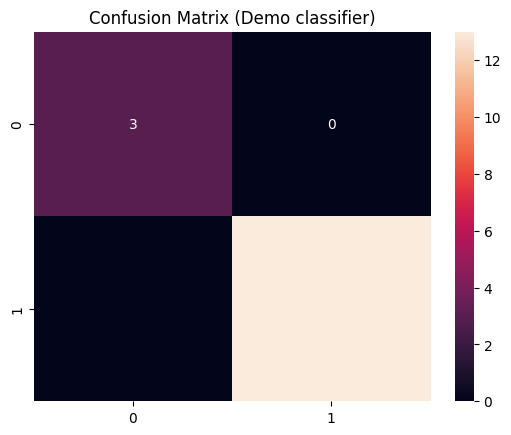

In [75]:
# Cell 12: Evaluation skeleton (requires 'label' column in final_df or separate truth file)
# Create or load labels if you have them; for prototype we'll create synthetic labels if none exist.

if 'label' not in final_df.columns:
    # if you have no ground truth, we can create a synthetic label based on final_score threshold for demo only
    final_df['label'] = final_df['final_score'] >= 75  # True == recommended
    print("No ground-truth labels found; synthetic labels created using threshold >=75 for demonstration.")

# Train/test split
X = final_df[['resume_points','personality_points']]  # simple features for demo
y = final_df['label'].astype(int)
if len(final_df) >= 10:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    # For demo, use a simple classifier (logistic regression)
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Eval (demo classifier) acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d'); plt.title("Confusion Matrix (Demo classifier)"); plt.show()
else:
    print("Not enough rows for meaningful train/test demonstration. Provide >=10 candidates to evaluate.")


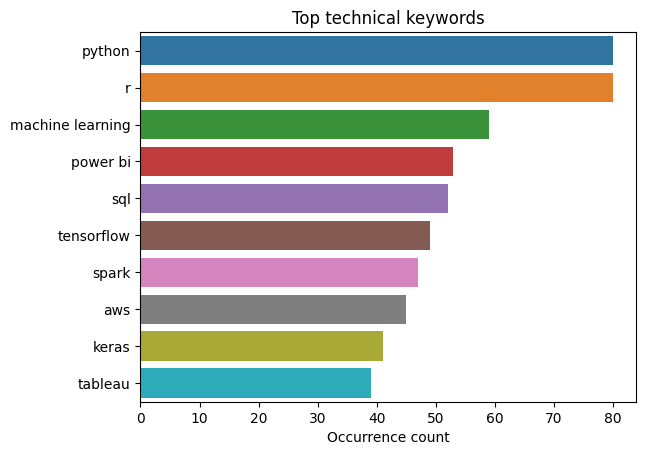

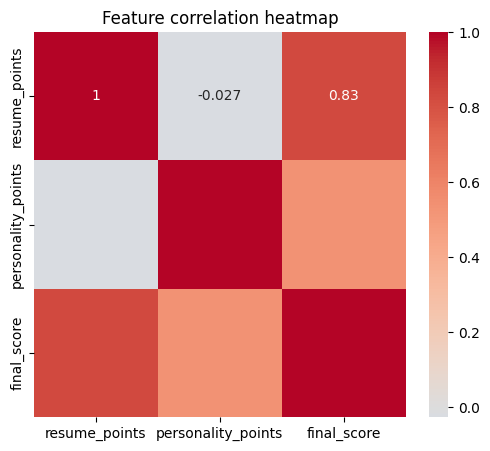

In [76]:
# Cell 13: Visualization helpers (produce thesis figures)

def plot_top_keywords(resume_texts, top_n=10):
    # resume_texts: list of raw texts
    from collections import Counter
    cnt = Counter()
    for t in resume_texts:
        tl = t.lower()
        for kw in DS_KEYWORDS:
            if kw in tl:
                cnt[kw] += 1
    top = cnt.most_common(top_n)
    if not top:
        print("No keywords found; ensure resumes loaded.")
        return
    k, v = zip(*top)
    sns.barplot(x=list(v), y=list(k))
    plt.xlabel("Occurrence count"); plt.title("Top technical keywords")
    plt.show()

def plot_correlation_heatmap(df_features):
    corr = df_features.corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title("Feature correlation heatmap")
    plt.show()

# Example usage:
if not resumes_df.empty:
    plot_top_keywords(resumes_df['text_raw'].tolist(), top_n=10)

if not final_df.empty:
    plot_correlation_heatmap(final_df[['resume_points','personality_points','final_score']])


In [77]:
# Cell 14: Save artifacts and produce quick report

# Save final df CSV (already saved), save a small JSON summary
summary = {
    "n_candidates": len(final_df),
    "avg_resume_points": float(final_df['resume_points'].mean()),
    "avg_personality_points": float(final_df['personality_points'].mean()),
    "avg_final_score": float(final_df['final_score'].mean())
}
with open(OUTPUT_DIR / "summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved summary.json")

# Optionally save the SBERT model locally (sentence-transformers has save methods)
try:
    model_save_path = MODEL_DIR / "sbert_model"
    sbert.save(str(model_save_path))
    print("Saved SBERT to", model_save_path)
except Exception as e:
    print("Could not save SBERT model:", e)

# Save a lightweight artifact for web demo (final_df -> JSON)
final_df.to_json(OUTPUT_DIR / "final_results.json", orient="records")
print("Saved final_results.json for web demo usage.")



INFO:sentence_transformers.SentenceTransformer:Save model to C:\Data Science & Business Analysis\Project Root\Data\models\sbert_model


Saved summary.json
Saved SBERT to C:\Data Science & Business Analysis\Project Root\Data\models\sbert_model
Saved final_results.json for web demo usage.
